In [1]:
#Naive bayes algorithm

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    classification_report, roc_auc_score, precision_recall_curve
)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.calibration import CalibrationDisplay

In [5]:
RANDOM_STATE = 42
PLOTS_DIR = "plots_nb"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [6]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")   # 1 = malignant? (sklearn: 0=malignant, 1=benign)
target_names = list(data.target_names)

In [8]:
print("Missing values per column:\n", X.isna().sum().sort_values(ascending=False))
print("\nClass balance:\n", y.value_counts())

Missing values per column:
 mean radius                0
mean texture               0
worst symmetry             0
worst concave points       0
worst concavity            0
worst compactness          0
worst smoothness           0
worst area                 0
worst perimeter            0
worst texture              0
worst radius               0
fractal dimension error    0
symmetry error             0
concave points error       0
concavity error            0
compactness error          0
smoothness error           0
area error                 0
perimeter error            0
texture error              0
radius error               0
mean fractal dimension     0
mean symmetry              0
mean concave points        0
mean concavity             0
mean compactness           0
mean smoothness            0
mean area                  0
mean perimeter             0
worst fractal dimension    0
dtype: int64

Class balance:
 target
1    357
0    212
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

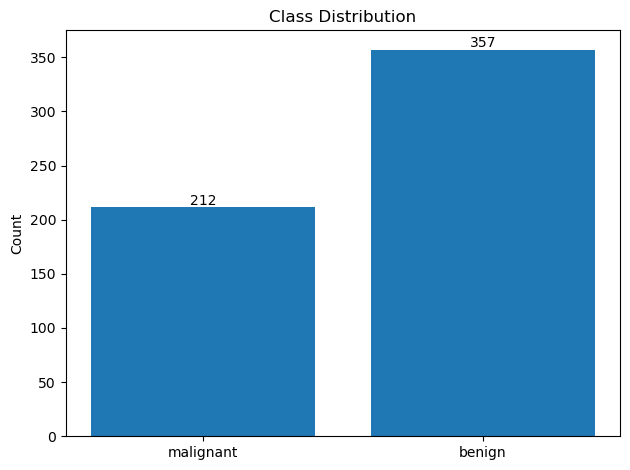

In [13]:
fig, ax = plt.subplots()
vals = y.value_counts().sort_index()
ax.bar([target_names[0], target_names[1]], vals.values)
ax.set_title("Class Distribution")
ax.set_ylabel("Count")
for i, v in enumerate(vals.values):
    ax.text(i, v + 2, str(v), ha='center')
fig.tight_layout()
plt.show()

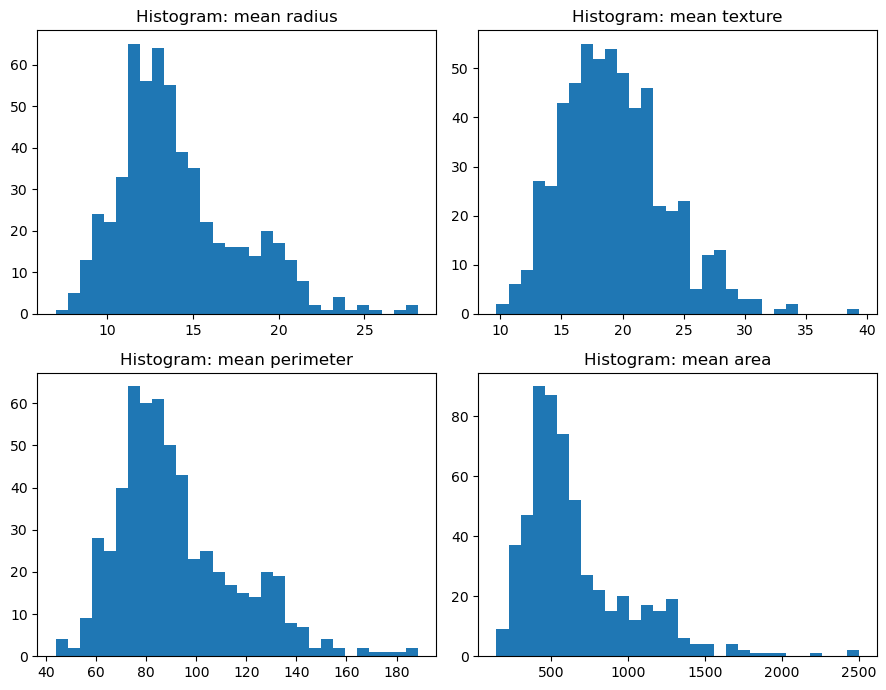

In [14]:
top_features = ["mean radius", "mean texture", "mean perimeter", "mean area"]
fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.ravel()
for i, f in enumerate(top_features):
    axes[i].hist(X[f], bins=30)
    axes[i].set_title(f"Histogram: {f}")
fig.tight_layout()
plt.show()


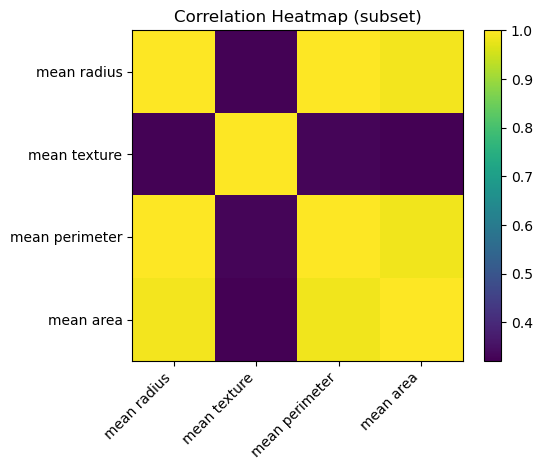

In [15]:
corr = X[top_features].corr()
fig, ax = plt.subplots()
im = ax.imshow(corr, interpolation='nearest')
ax.set_xticks(range(len(top_features))); ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.set_yticks(range(len(top_features))); ax.set_yticklabels(top_features)
ax.set_title("Correlation Heatmap (subset)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()

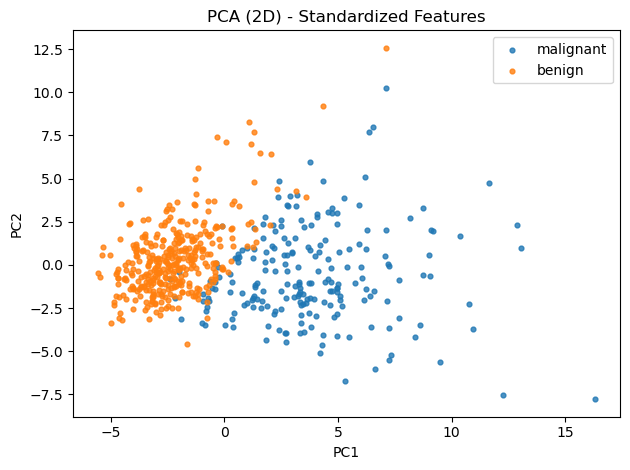

In [16]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_std)

fig, ax = plt.subplots()
for t in np.unique(y):
    ax.scatter(X_pca[y==t, 0], X_pca[y==t, 1], label=target_names[t], s=12, alpha=0.8)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("PCA (2D) - Standardized Features")
ax.legend()
fig.tight_layout()

In [17]:
pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("model", GaussianNB())
])

# Hyperparameter to tune for GaussianNB: var_smoothing
param_grid = {
    "model__var_smoothing": np.logspace(-12, -6, 13)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    refit=True
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("CV ROC-AUC (mean):", grid.best_score_)

best_model = grid.best_estimator_

Best params: {'model__var_smoothing': 1e-12}
CV ROC-AUC (mean): 0.9858961841482383


In [18]:
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("\nTest ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


Test ROC-AUC: 0.9878406708595389

Classification Report:
               precision    recall  f1-score   support

   malignant       0.94      0.89      0.91        53
      benign       0.94      0.97      0.95        90

    accuracy                           0.94       143
   macro avg       0.94      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



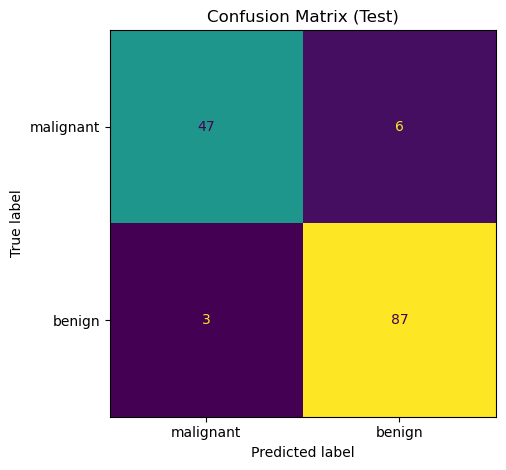

In [19]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax, values_format="d", colorbar=False)
ax.set_title("Confusion Matrix (Test)")
fig.tight_layout()


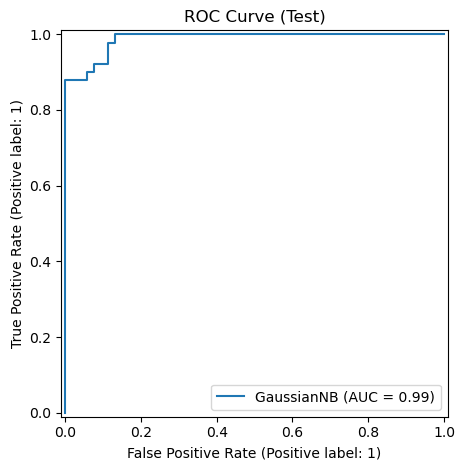

In [20]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax, name="GaussianNB")
ax.set_title("ROC Curve (Test)")
fig.tight_layout()

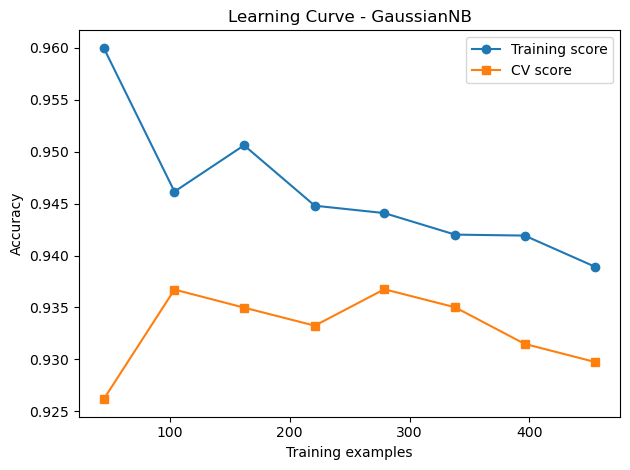

In [21]:
fig, ax = plt.subplots()
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=cv, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True, random_state=RANDOM_STATE
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
ax.plot(train_sizes, train_mean, marker='o', label="Training score")
ax.plot(train_sizes, val_mean, marker='s', label="CV score")
ax.set_xlabel("Training examples"); ax.set_ylabel("Accuracy")
ax.set_title("Learning Curve - GaussianNB")
ax.legend()
fig.tight_layout()

In [22]:
best_model.fit(X_train, y_train)
gnb = best_model.named_steps["model"]

# Extract feature names (match the pipeline input)
feature_names = X.columns

means = pd.DataFrame(
    gnb.theta_,  # shape: (n_classes, n_features)
    index=target_names,
    columns=feature_names
)
stds = pd.DataFrame(
    np.sqrt(gnb.var_),
    index=target_names,
    columns=feature_names
)


In [23]:
mean_diff = (means.loc[target_names[1]] - means.loc[target_names[0]]).abs().sort_values(ascending=False)
top10 = mean_diff.head(10).index.tolist()


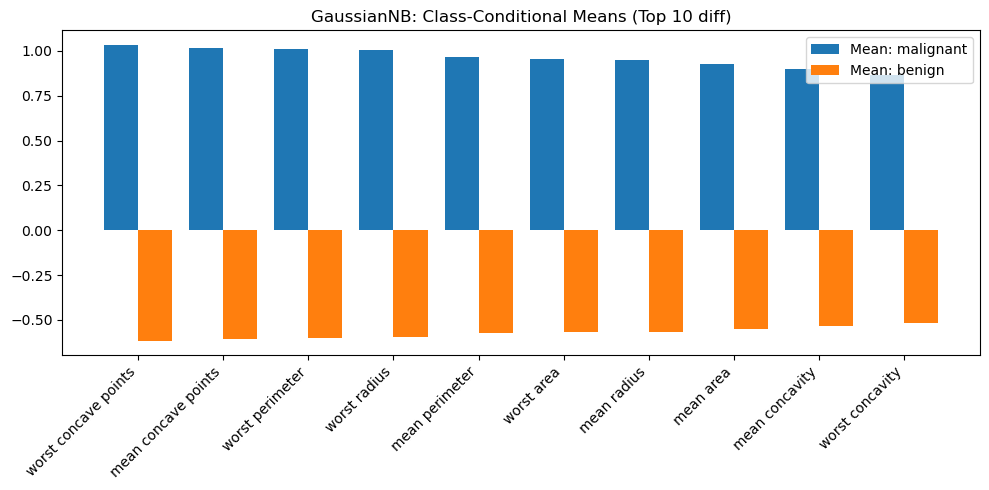

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
xpos = np.arange(len(top10))
ax.bar(xpos - 0.2, means.loc[target_names[0], top10].values, width=0.4, label=f"Mean: {target_names[0]}")
ax.bar(xpos + 0.2, means.loc[target_names[1], top10].values, width=0.4, label=f"Mean: {target_names[1]}")
ax.set_xticks(xpos); ax.set_xticklabels(top10, rotation=45, ha='right')
ax.set_title("GaussianNB: Class-Conditional Means (Top 10 diff)")
ax.legend()
fig.tight_layout()